# Cirrhosis New Competition

### 변수 설명
- ID                 : 환자 ID
- N_Days             : 등록 시작 시점부터 censored 까지 기간
- Status             : 
- Drug               : 약물 처리군 / 플라시보 군
- Age                : 연령
- Sex                : 성별
- Ascites            : Y/N 배에 복수가 찼는지
- Hepatomegaly       : Y/N 간 비대칭이 생겼는지
- Spiders            : Y/N 거미혈관증 유무 주로 여성에게 많이 발생할 수 있음 ( 에스트로겐과 관련 )
- Edema              : Y/N 부종 유무
- Bilirubin          : 적혈구 파괴 수치 (파괴 수치가 높을수록 간염이 존재할 확률이 높음)
- Cholesterol        : 콜레스테롤 상승시 지방간이 생김 ( 높을수록 간에 안좋음 )
- Albumin            : 단백질의 한 종류 (값이 하락할 수록 간 기능이 안좋음)
- Copper             : 신체의 필수 미네랄 하나 (단백질, 효소) 수치가 높을 수록 대사 장애 발생 가능성 높음
- Alk_Phos           : (alp) 수치가 높으면 간의 문제가 있을 가능성 높음
- SGOT               : (AST) 간기능 검사의 주요 요소 [0, 40]이 정상 범위
- Tryglicerides      : 중성지방 150 미만이 정상.
- Platelets          : 혈소판 수치가 떨어질 수록 간 경변이 발생 가능
- Prothrombin        : 혈액이 얼마나 빨리 굳는지 측정 시간 ( 시간이 증가하면 응고 시간이 늘어나기 때문에 간경변 의심할 수 있음, 높을수록 의심)
- Stage              : 간경변의 4단계 1부터 4까지의 순서

## 1. Setting

In [1]:
# import modules
import pandas as pd
import numpy as np
import warnings

# graph
from matplotlib import pyplot as plt
import seaborn as sns

# data imbalanced
from imblearn.over_sampling import SMOTE

# modeling
from supervised.automl import AutoML

%matplotlib inline

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# 한글 깨짐 방지 및 warnings 알림 금지
plt.rc('font', family='NanumSquare')
warnings.filterwarnings(action = 'ignore')

In [3]:
# load data
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')
submission = pd.read_csv('../Data/sample_submission.csv')

## 2. Data preprocess

In [4]:
# remove id
use_train = train.drop(['id'], axis = 1)
use_test = test.drop(['id'], axis = 1)

In [5]:
use_train

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,1166,D-penicillamine,16839,F,N,N,N,N,0.8,309.0,3.56,38.0,1629.0,79.05,224.0,344.0,9.9,2.0,C
7901,1492,Placebo,17031,F,N,Y,N,N,0.9,260.0,3.43,62.0,1440.0,142.00,78.0,277.0,10.0,4.0,C
7902,1576,D-penicillamine,25873,F,N,N,Y,S,2.0,225.0,3.19,51.0,933.0,69.75,62.0,200.0,12.7,2.0,D
7903,3584,D-penicillamine,22960,M,N,Y,N,N,0.7,248.0,2.75,32.0,1003.0,57.35,118.0,221.0,10.6,4.0,D


In [6]:
# data setting
def cate_numeric(column, new_column, zero_value):
    global use_train, use_test
    use_train[new_column] = np.where(use_train[column] == zero_value, 0, 1)
    use_test[new_column] = np.where(use_test[column] == zero_value, 0, 1)
    use_train = use_train.drop([column], axis = 1)
    return use_train, use_test

In [7]:
# get
cate_numeric('Drug', 'Drugs', 'Placebo')
cate_numeric('Sex', 'Gender', 'M')
cate_numeric('Ascites', 'AscitesYN', 'N')
cate_numeric('Hepatomegaly', 'HepatomegalyYN', 'N')
cate_numeric('Spiders', 'SpidersYN', 'N')

(      N_Days    Age Edema  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos  \
 0        999  21532     N        2.3        316.0     3.35   172.0    1601.0   
 1       2574  19237     N        0.9        364.0     3.54    63.0    1440.0   
 2       3428  13727     Y        3.3        299.0     3.55   131.0    1029.0   
 3       2576  18460     N        0.6        256.0     3.50    58.0    1653.0   
 4        788  16658     N        1.1        346.0     3.65    63.0    1181.0   
 ...      ...    ...   ...        ...          ...      ...     ...       ...   
 7900    1166  16839     N        0.8        309.0     3.56    38.0    1629.0   
 7901    1492  17031     N        0.9        260.0     3.43    62.0    1440.0   
 7902    1576  25873     S        2.0        225.0     3.19    51.0     933.0   
 7903    3584  22960     N        0.7        248.0     2.75    32.0    1003.0   
 7904    1978  19237     N        0.7        256.0     3.23    22.0     645.0   
 
         SGOT  Tryglicerid

In [8]:
# labelencoding
cri_train = [use_train['Edema'] == 'Y',
       use_train['Edema'] == 'S']

cri_test = [use_test['Edema'] == 'Y',
       use_test['Edema'] == 'S']

contents = [1, -1]

use_train['Edemas'] = np.select(cri_train, contents, default = 0)
use_test['Edemas'] = np.select(cri_test, contents, default = 0)
use_train2 = use_train.drop(['Edema'], axis = 1)
use_test2 = use_test.drop(['Edema'], axis = 1)

In [9]:
# status
cri_train2 = [use_train2['Status'] == 'C',
       use_train2['Status'] == 'D']

contents = [0, 1]

use_train2['Target'] = np.select(cri_train2, contents, default = 2)
use_train3 = use_train2.drop(['Status'], axis = 1)

In [10]:
use_train3.columns

Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Drugs', 'Gender', 'AscitesYN', 'HepatomegalyYN', 'SpidersYN',
       'Edemas', 'Target'],
      dtype='object')

## 3. data log1p by skwed data

In [11]:
# select skwed columns
moved_data = ['Bilirubin', 'Cholesterol', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Prothrombin']

In [12]:
# copy data
use_train4 = use_train3.copy()
use_test4 = use_test2.copy()

In [13]:
# trans
use_train4[moved_data] = np.log1p(use_train3[moved_data])
use_test4[moved_data] = np.log1p(use_test2[moved_data])

In [14]:
patients = use_train4.copy()
features = patients.columns.tolist()
features.pop() # getting rid of the target 'Status'
target = use_train4['Target']

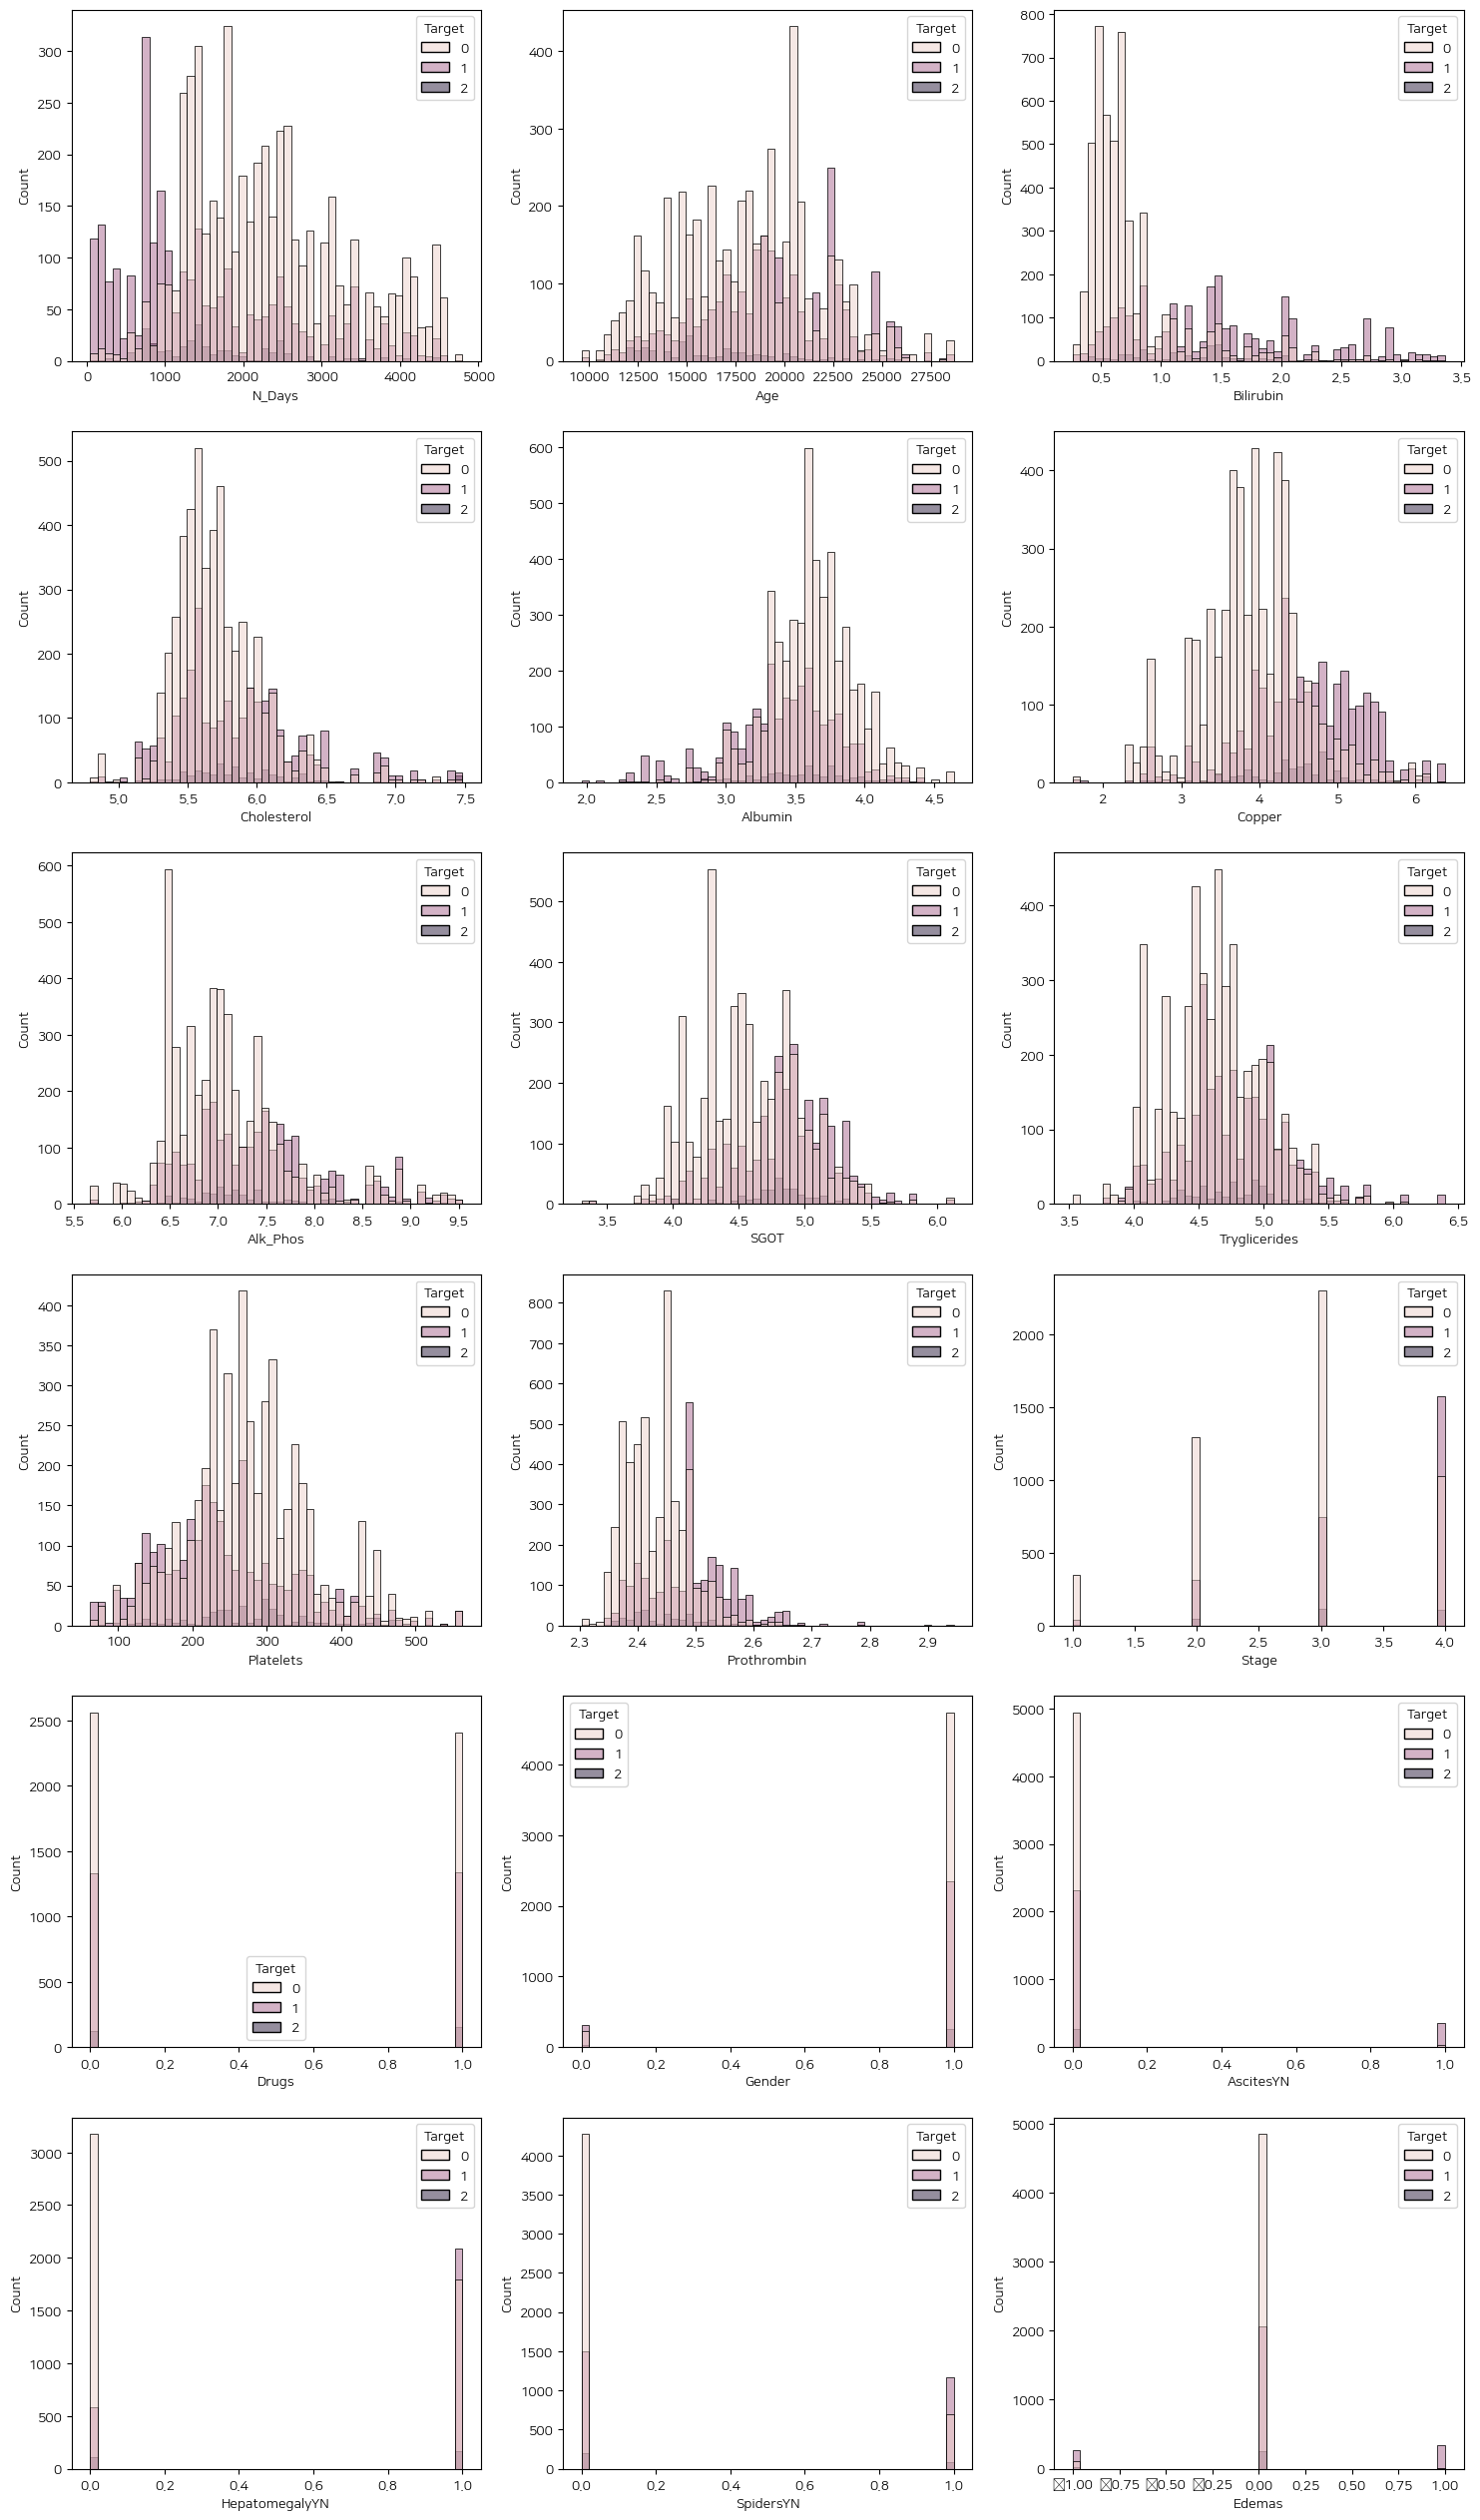

In [15]:
_, axes = plt.subplots(nrows= 6, ncols=3, figsize=(18,32))
for feat, ax in zip(features, axes.ravel()):
    if patients[feat].dtype == 'object':
        sns.countplot(data=patients, x=feat, ax=ax, hue='Target')
    else:
        sns.histplot(data=patients, x=feat, bins=50, ax=ax, hue='Target')
plt.show()

## 4. SMOTE

In [16]:
# 모델설정
sm = SMOTE(random_state=42)

# train데이터를 넣어 복제함
x_train_smote, y_train_smote = sm.fit_resample(use_train4[use_train4.columns.difference(['Target'])],list(use_train4['Target']))

In [17]:
# dataframe화
y_train = pd.DataFrame(y_train_smote, columns = ['Target'])

## 5. Modeling

In [18]:
# model
automl = AutoML(mode="Compete",
                algorithms = ['LightGBM',
                            'Xgboost',
                            'CatBoost'],
                n_jobs = -1,
                total_time_limit=43200,
                random_state = 42,
                eval_metric="logloss",
                ml_task = "multiclass_classification",
                results_path = '../Model/AutoML_logloss_smote_skwed_data_log1p/',
                explain_level=2)

In [19]:
# fit
automl.fit(x_train_smote, y_train)

AutoML directory: ../Model/AutoML_logloss_smote_skwed_data_log1p/
The task is multiclass_classification with evaluation metric logloss
AutoML will use algorithms: ['LightGBM', 'Xgboost', 'CatBoost']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['adjust_validation', 'simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
* Step adjust_validation will try to check up to 1 model
1_DecisionTree logloss 0.755496 trained in 40.32 seconds
Adjust validation. Remove: 1_DecisionTree
Validation strategy: 10-fold CV Shuffle,Stratify
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 3 models
1_Default_LightGBM logloss 0.249365 trained in 509.03 seconds
2_Default_Xgboost logloss 0.257122 trained in 313.59 seconds
3_Default_C

AutoML(algorithms=['LightGBM', 'Xgboost', 'CatBoost'], eval_metric='logloss',
       explain_level=2, ml_task='multiclass_classification', mode='Compete',
       random_state=42,
       results_path='../Model/AutoML_logloss_smote_skwed_data_log1p/',
       total_time_limit=43200)

In [20]:
# predict test data
preds = automl.predict_proba(use_test4)

In [22]:
preds

array([[0.49061094, 0.49438941, 0.01499965],
       [0.83550686, 0.12322804, 0.0412651 ],
       [0.00568354, 0.99126447, 0.00305199],
       ...,
       [0.96211342, 0.03261378, 0.0052728 ],
       [0.99281559, 0.00411043, 0.00307398],
       [0.17009291, 0.81790506, 0.01200204]])

In [23]:
baseline_submission

,id,Status_C,Status_CL,Status_D
0,7905,0.628084,0.034788,0.337128
1,7906,0.628084,0.034788,0.337128
2,7907,0.628084,0.034788,0.337128
3,7908,0.628084,0.034788,0.337128
4,7909,0.628084,0.034788,0.337128
...,...,...,...,...
5266,13171,0.628084,0.034788,0.337128
5267,13172,0.628084,0.034788,0.337128
5268,13173,0.628084,0.034788,0.337128
5269,13174,0.628084,0.034788,0.337128


In [27]:
# submission 만들기
sample_submission = pd.read_csv('../Data/sample_submission.csv')
baseline_submission = sample_submission.copy()
baseline_submission[['Status_C', 'Status_CL', 'Status_D']] = preds
baseline_submission.to_csv('../Data/AutoML_logloss_smote_skwed_data_log1p.csv', index = False, encoding = 'cp949')